### ------Import libraries--------

In [1]:
from pyspark.sql import SparkSession , SQLContext
from pyspark.sql.functions import col,isnan, when, count
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as f

#### Create spark session

In [2]:
spark = SparkSession.builder.master('local[*]').appName('Fraud Sys detection').getOrCreate()

### --------EDA----------

In [3]:
data = spark.read.csv('fraudData.csv',sep =',',header = True)

In [4]:
data.take(3)

[Row(step='1', type='PAYMENT', amount='9839.64', nameOrig='C1231006815', oldbalanceOrg='170136.0', newbalanceOrig='160296.36', nameDest='M1979787155', oldbalanceDest='0.0', newbalanceDest='0.0', isFraud='0', isFlaggedFraud='0'),
 Row(step='1', type='PAYMENT', amount='1864.28', nameOrig='C1666544295', oldbalanceOrg='21249.0', newbalanceOrig='19384.72', nameDest='M2044282225', oldbalanceDest='0.0', newbalanceDest='0.0', isFraud='0', isFlaggedFraud='0'),
 Row(step='1', type='TRANSFER', amount='181.0', nameOrig='C1305486145', oldbalanceOrg='181.0', newbalanceOrig='0.0', nameDest='C553264065', oldbalanceDest='0.0', newbalanceDest='0.0', isFraud='1', isFlaggedFraud='0')]

In [5]:
data.cache()

DataFrame[step: string, type: string, amount: string, nameOrig: string, oldbalanceOrg: string, newbalanceOrig: string, nameDest: string, oldbalanceDest: string, newbalanceDest: string, isFraud: string, isFlaggedFraud: string]

In [6]:
data.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)



In [7]:
cols_to_convert = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']

In [8]:
for col_name in cols_to_convert:
    data = data.withColumn(col_name, data[col_name].cast('float').alias(col_name))

In [9]:
data.printSchema()

root
 |-- step: float (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: float (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: float (nullable = true)
 |-- newbalanceOrig: float (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: float (nullable = true)
 |-- newbalanceDest: float (nullable = true)
 |-- isFraud: float (nullable = true)
 |-- isFlaggedFraud: float (nullable = true)



In [10]:
print((data.count(),len(data.columns)))

(6362620, 11)


In [11]:
data.describe(['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']).show()

+-------+-----------------+------------------+-----------------+------------------+-----------------+
|summary|           amount|     oldbalanceOrg|   newbalanceOrig|    oldbalanceDest|   newbalanceDest|
+-------+-----------------+------------------+-----------------+------------------+-----------------+
|  count|          6362620|           6362620|          6362620|           6362620|          6362620|
|   mean|179861.9035579989| 833883.1040482761|855113.6685519279|1100701.6665156623|1224996.398184315|
| stddev|603858.2316772637|2888242.6729989178|2924048.502910317|3399180.1117577194|3674128.941013759|
|    min|              0.0|               0.0|              0.0|               0.0|              0.0|
|    max|       9.244552E7|        5.958504E7|       4.958504E7|      3.56015904E8|     3.56179264E8|
+-------+-----------------+------------------+-----------------+------------------+-----------------+



In [12]:
transbytype = data.groupBy('type').count().toPandas()

In [13]:
transbytype

,type,count
0,TRANSFER,532909
1,CASH_IN,1399284
2,CASH_OUT,2237500
3,PAYMENT,2151495
4,DEBIT,41432


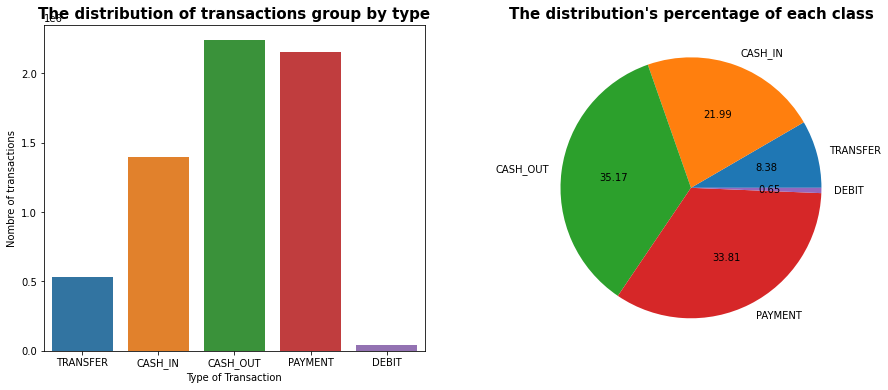

In [14]:
plt.subplots(1,2,figsize=(15,6))

plt.subplot(1,2,1)
sns.barplot(x='type',y='count', data=transbytype)
plt.xlabel('Type of Transaction')
plt.ylabel('Nombre of transactions',)
plt.title('The distribution of transactions group by type', fontsize=15, fontweight='bold')

plt.subplot(1,2,2)
plt.pie(transbytype['count'], labels=transbytype['type'], autopct='%.2f')
plt.title('The distribution\'s percentage of each class', fontsize=15, fontweight='bold')
plt.show()

In [15]:
data.groupBy('type').sum('amount').show(truncate = False)

+--------+--------------------+
|type    |sum(amount)         |
+--------+--------------------+
|TRANSFER|4.852919873022494E11|
|CASH_IN |2.363673919156044E11|
|CASH_OUT|3.944129952377687E11|
|PAYMENT |2.809337113918083E10|
|DEBIT   |2.271992213932485E8 |
+--------+--------------------+



In [16]:
fraudbytype = data.groupBy('type').sum('isFraud').toPandas()

###### fraudbytype

Text(0.5, 1.0, 'Nombre of fraud cases by type')

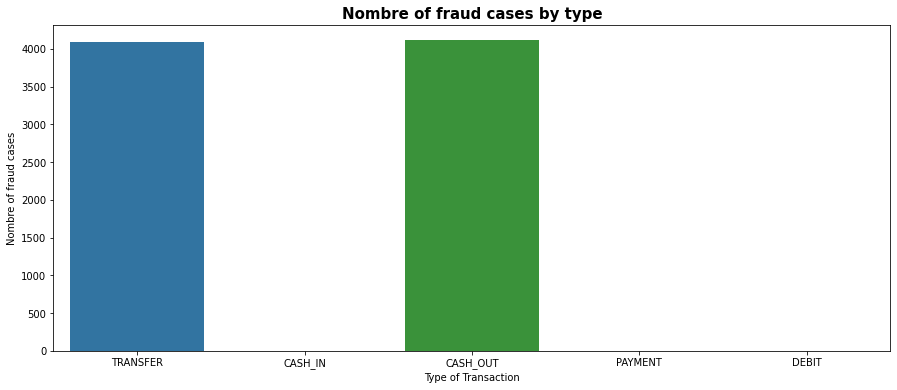

In [17]:
plt.figure(figsize=(15,6))

sns.barplot(x='type',y='sum(isFraud)', data=fraudbytype)
plt.xlabel('Type of Transaction')
plt.ylabel('Nombre of fraud cases')
plt.title('Nombre of fraud cases by type', fontsize=15, fontweight='bold')

In [18]:
fraud_count = data.groupBy('isFraud').count().toPandas()

In [19]:
fraud_count

,isFraud,count
0,1.0,8213
1,0.0,6354407


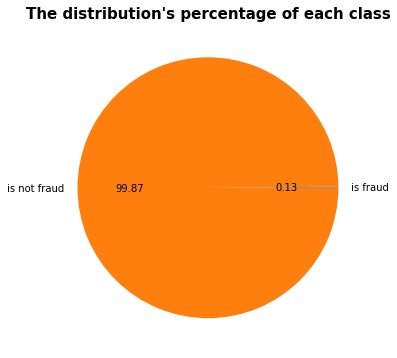

In [20]:
plt.figure(figsize=(15,6))
plt.pie(fraud_count['count'], labels=['is fraud' , 'is not fraud'], autopct='%.2f')
plt.title('The distribution\'s percentage of each class', fontsize=15, fontweight='bold')
plt.show()

In [21]:
data.groupBy('isFlaggedFraud').count().show(truncate = False)

+--------------+-------+
|isFlaggedFraud|count  |
+--------------+-------+
|1.0           |16     |
|0.0           |6362604|
+--------------+-------+



In [22]:
data.groupBy('type').sum('isFlaggedFraud').show(truncate = False)

+--------+-------------------+
|type    |sum(isFlaggedFraud)|
+--------+-------------------+
|TRANSFER|16.0               |
|CASH_IN |0.0                |
|CASH_OUT|0.0                |
|PAYMENT |0.0                |
|DEBIT   |0.0                |
+--------+-------------------+



In [23]:
numeric_features = ['step','amount', 'oldbalanceOrg',
                    'newbalanceOrig','oldbalanceDest', 
                    'newbalanceDest']

numeric_data = data.select(numeric_features).limit(1000000).toPandas()

<Figure size 2160x2160 with 0 Axes>

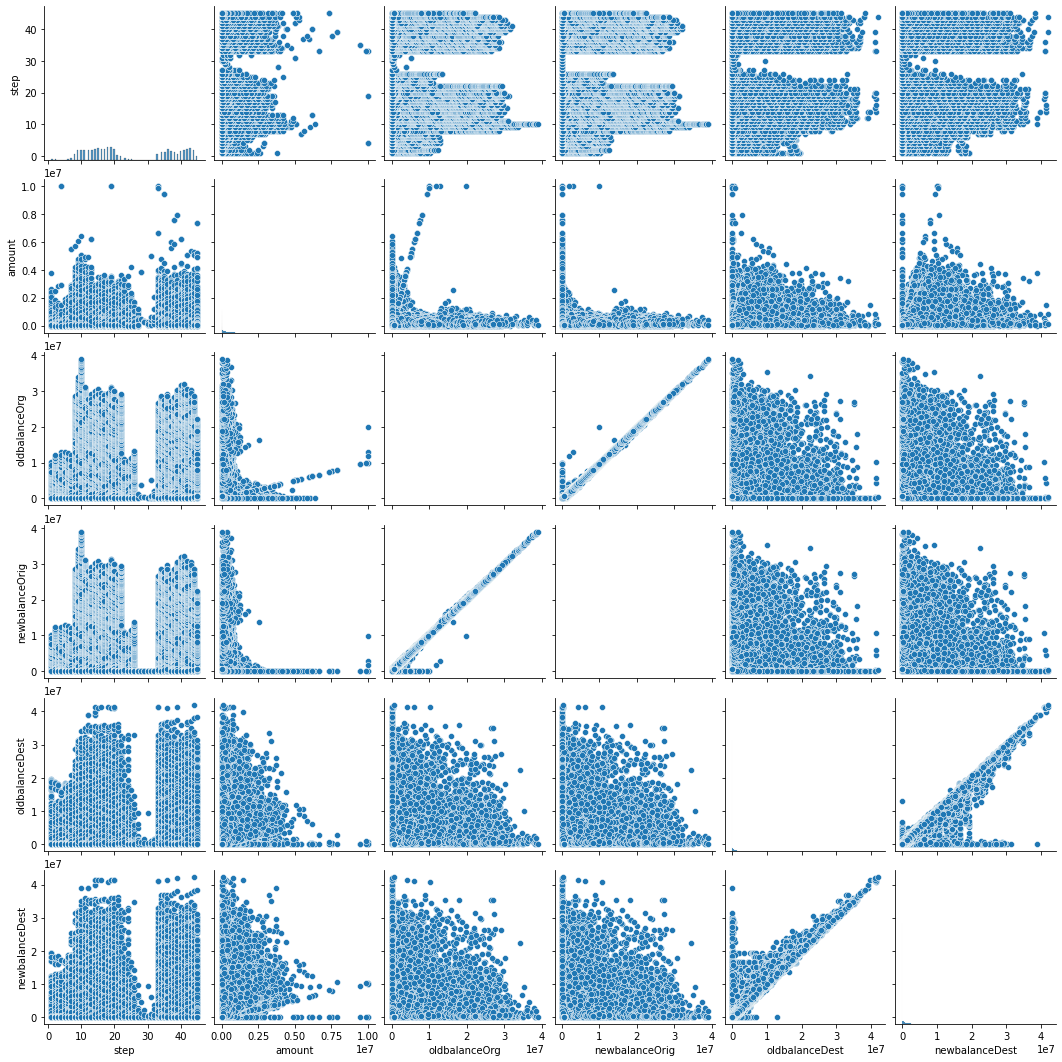

In [24]:

plt.figure(figsize = (30,30))
sns.pairplot(numeric_data)
plt.show()

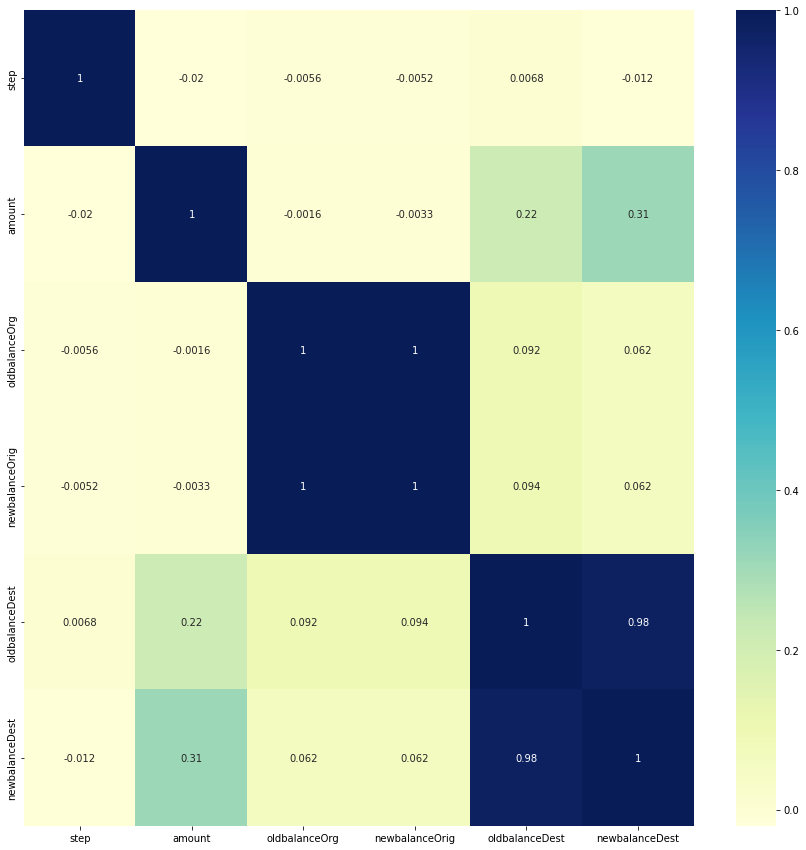

In [25]:
plt.figure(figsize = (15,15))
sns.heatmap(numeric_data.corr(), annot = True ,cmap = 'YlGnBu')
plt.show()

#### Comparison between TRANSFER transactions flagged as fraud and ones that are not

In [26]:
transferdata = data.filter(f.col('type')=='TRANSFER').toPandas()

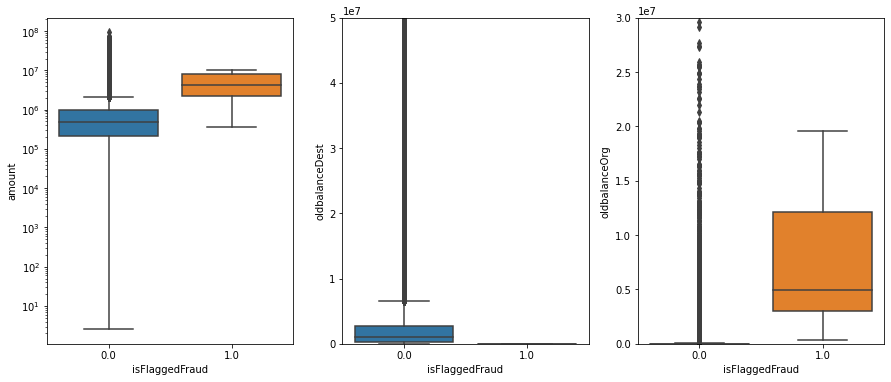

In [27]:

fig, axs = plt.subplots(1, 3, figsize=(15, 6), squeeze=False)

a = sns.boxplot(x = 'isFlaggedFraud', y = 'amount', data = transferdata, ax=axs[0][0])
axs[0][0].set_yscale('log')
b = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceDest', data = transferdata , ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))
c = sns.boxplot(x = 'isFlaggedFraud', y = 'oldbalanceOrg', data=transferdata, ax=axs[0][2])
axs[0][2].set(ylim=(0, 3e7))

plt.show()

#### Count null values

In [28]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



#### Count duplicate records

In [29]:
data.groupBy(data.columns).count().where(f.col('count') > 1).select(f.sum('count')).show()

+----------+
|sum(count)|
+----------+
|      null|
+----------+



### Preprocessing

In [30]:
cols = ("step","isFlaggedFraud","nameOrig","nameDest")

data = data.drop(*cols)

In [31]:
data.select('type').distinct().collect()

[Row(type='TRANSFER'),
 Row(type='CASH_IN'),
 Row(type='CASH_OUT'),
 Row(type='PAYMENT'),
 Row(type='DEBIT')]

In [32]:
data = data.filter((data.type=="TRANSFER") | (data.type=="CASH_OUT"))

In [33]:
from pyspark.ml.feature import StringIndexer

type_indexer = StringIndexer(inputCol="type", outputCol="numeric_type")
data = type_indexer.fit(data).transform(data)
data = data.drop('type')
data.show(5)

+---------+-------------+--------------+--------------+--------------+-------+------------+
|   amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|numeric_type|
+---------+-------------+--------------+--------------+--------------+-------+------------+
|    181.0|        181.0|           0.0|           0.0|           0.0|    1.0|         1.0|
|    181.0|        181.0|           0.0|       21182.0|           0.0|    1.0|         0.0|
|229133.94|      15325.0|           0.0|        5083.0|      51513.44|    0.0|         0.0|
| 215310.3|        705.0|           0.0|       22425.0|           0.0|    0.0|         1.0|
|311685.88|      10835.0|           0.0|        6267.0|     2719173.0|    0.0|         1.0|
+---------+-------------+--------------+--------------+--------------+-------+------------+
only showing top 5 rows



In [34]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
                                       'newbalanceDest','numeric_type'], outputCol='features')
df = assembler.transform(data)

In [35]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(df)


In [36]:
scaledData.show(4)

+---------+-------------+--------------+--------------+--------------+-------+------------+--------------------+--------------------+
|   amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|numeric_type|            features|      scaledFeatures|
+---------+-------------+--------------+--------------+--------------+-------+------------+--------------------+--------------------+
|    181.0|        181.0|           0.0|           0.0|           0.0|    1.0|         1.0|[181.0,181.0,0.0,...|[1.95790991277889...|
|    181.0|        181.0|           0.0|       21182.0|           0.0|    1.0|         0.0|[181.0,181.0,0.0,...|[1.95790991277889...|
|229133.94|      15325.0|           0.0|        5083.0|      51513.44|    0.0|         0.0|[229133.9375,1532...|[0.00247858346732...|
| 215310.3|        705.0|           0.0|       22425.0|           0.0|    0.0|         1.0|[215310.296875,70...|[0.00232905063301...|
+---------+-------------+--------------+--------------+-------

### Split data

In [37]:
(train, test )= df.randomSplit([0.9, 0.1], seed=2022)

In [38]:
train.show(5)

+------+-------------+--------------+--------------+--------------+-------+------------+--------------------+
|amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|numeric_type|            features|
+------+-------------+--------------+--------------+--------------+-------+------------+--------------------+
|  0.37|      25032.0|      25031.63|           0.0|           0.0|    0.0|         0.0|[0.37000000476837...|
|  1.58|          0.0|           0.0|     197938.48|       70090.2|    0.0|         0.0|[1.58000004291534...|
|  1.65|          0.0|           0.0|     6653022.5|     6653024.5|    0.0|         0.0|[1.64999997615814...|
|   1.9|      18399.0|       18397.1|   1.1306069E7|   1.1306071E7|    0.0|         0.0|[1.89999997615814...|
|  2.05|          0.0|           0.0|     243703.05|      243705.1|    0.0|         0.0|[2.04999995231628...|
+------+-------------+--------------+--------------+--------------+-------+------------+--------------------+
only showi

In [39]:
train.groupBy('isFraud').count().show(truncate = False)

+-------+-------+
|isFraud|count  |
+-------+-------+
|1.0    |7403   |
|0.0    |2486403|
+-------+-------+



### resolving imbalanced data problem

In [41]:
from pyspark.sql.functions import explode
from pyspark.sql.functions import array
from pyspark.sql.functions import lit

In [42]:
major_df=train.filter(col("isFraud") == 0)
minor_df=train.filter(col("isFraud") == 1)
ratio = int(major_df.count()/(10*minor_df.count()))
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("isF", explode(array([lit(x) for x in a]))).drop('isF')
# combine both oversampled minority rows and previous majority rows 
combined_df =major_df.unionAll(oversampled_df)
combined_df.show(5)

+------+-------------+--------------+--------------+--------------+-------+------------+--------------------+
|amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|numeric_type|            features|
+------+-------------+--------------+--------------+--------------+-------+------------+--------------------+
|  0.37|      25032.0|      25031.63|           0.0|           0.0|    0.0|         0.0|[0.37000000476837...|
|  1.58|          0.0|           0.0|     197938.48|       70090.2|    0.0|         0.0|[1.58000004291534...|
|  1.65|          0.0|           0.0|     6653022.5|     6653024.5|    0.0|         0.0|[1.64999997615814...|
|   1.9|      18399.0|       18397.1|   1.1306069E7|   1.1306071E7|    0.0|         0.0|[1.89999997615814...|
|  2.05|          0.0|           0.0|     243703.05|      243705.1|    0.0|         0.0|[2.04999995231628...|
+------+-------------+--------------+--------------+--------------+-------+------------+--------------------+
only showi

In [43]:
combined_df.limit(5).toPandas()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,numeric_type,features
0,0.37,25032.0,25031.630859,0.000000e+00,0.000000e+00,0.0,0.0,"[0.3700000047683716, 25032.0, 25031.630859375,..."
1,1.58,0.0,0.000000,1.979385e+05,7.009020e+04,0.0,0.0,"[1.5800000429153442, 0.0, 0.0, 197938.484375, ..."
2,1.65,0.0,0.000000,6.653022e+06,6.653024e+06,0.0,0.0,"[1.649999976158142, 0.0, 0.0, 6653022.5, 66530..."
3,1.90,18399.0,18397.099609,1.130607e+07,1.130607e+07,0.0,0.0,"[1.899999976158142, 18399.0, 18397.099609375, ..."
4,2.05,0.0,0.000000,2.437030e+05,2.437051e+05,0.0,0.0,"[2.049999952316284, 0.0, 0.0, 243703.046875, 2..."


In [45]:
combined_df.groupBy('isFraud').count().show(truncate = False)

+-------+-------+
|isFraud|count  |
+-------+-------+
|1.0    |244299 |
|0.0    |2486403|
+-------+-------+



### Modeling

#### Logistic Regression

In [40]:
from pyspark.ml.classification import LogisticRegression
logistic = LogisticRegression(labelCol = "isFraud", featuresCol = "features")
lrModel = logistic.fit(train)

In [41]:
prediction_LR = lrModel.transform(test)

In [42]:
prediction_LR.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|    1.0|       0.0|   430|
|    0.0|       0.0|275753|
|    1.0|       1.0|   380|
|    0.0|       1.0|    40|
+-------+----------+------+



In [43]:
tp = prediction_LR[(prediction_LR.isFraud == 1) & (prediction_LR.prediction == 1)].count()
tn = prediction_LR[(prediction_LR.isFraud == 0) & (prediction_LR.prediction == 0)].count()
fp = prediction_LR[(prediction_LR.isFraud == 0) & (prediction_LR.prediction == 1)].count()
fn = prediction_LR[(prediction_LR.isFraud == 1) & (prediction_LR.prediction == 0)].count()
recall_LR = tp/(tp+fn)
precision_LR = tp/(tp+fp)
f1_score_LR = 2*(recall_LR*precision_LR)/(recall_LR+precision_LR)
print("Recall : ",recall_LR)
print("Precision : ", precision_LR)
print("F1 Score : ", f1_score_LR)

Recall :  0.4691358024691358
Precision :  0.9047619047619048
F1 Score :  0.6178861788617886


In [44]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
areaUnderROC_LR = evaluator.evaluate(prediction_LR, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_LR)

Area under ROC = 0.9831340807452497


In [45]:
areaUnderPR_LR = evaluator.evaluate(prediction_LR, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_LR)

Area under PR = 0.6665939046903049


#### Naive bayes

In [46]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="isFraud", featuresCol="features", smoothing=1.0, modelType="multinomial")
nb_model = nb.fit(train)

In [47]:
prediction_NB = nb_model.transform(test)

In [48]:
prediction_NB.groupBy("isFraud", "prediction").count().show()

+-------+----------+------+
|isFraud|prediction| count|
+-------+----------+------+
|    1.0|       0.0|   110|
|    0.0|       0.0|208676|
|    1.0|       1.0|   700|
|    0.0|       1.0| 67117|
+-------+----------+------+



In [49]:
tp = prediction_NB[(prediction_NB.isFraud == 1) & (prediction_NB.prediction == 1)].count()
tn = prediction_NB[(prediction_NB.isFraud == 0) & (prediction_NB.prediction == 0)].count()
fp = prediction_NB[(prediction_NB.isFraud == 0) & (prediction_NB.prediction == 1)].count()
fn = prediction_NB[(prediction_NB.isFraud == 1) & (prediction_NB.prediction == 0)].count()
recall_NB = tp/(tp+fn)
precision_NB = tp/(tp+fp)
f1_score_NB = 2*(recall_NB*precision_NB)/(recall_NB+precision_NB)
print("Recall : ",recall_NB)
print("Precision : ", precision_NB)
print("F1 Score : ", f1_score_NB)

Recall :  0.8641975308641975
Precision :  0.01032189568987127
F1 Score :  0.02040013405802381


In [50]:
areaUnderROC_NB = evaluator.evaluate(prediction_NB, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_NB)

Area under ROC = 0.5626975644150937


In [51]:
areaUnderPR_NB = evaluator.evaluate(prediction_NB, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_NB)

Area under PR = 0.008746362879704742


#### Gradient-Boosted Tree Classifier

In [54]:
from pyspark.ml.classification import GBTClassifier

# Train a GBT model.
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features", maxIter=10)

# Train model. 
gbt_model = gbt.fit(train)

In [55]:
prediction_GBT = gbt_model.transform(test)

In [56]:
tp = prediction_GBT[(prediction_GBT.isFraud == 1) & (prediction_GBT.prediction == 1)].count()
tn = prediction_GBT[(prediction_GBT.isFraud == 0) & (prediction_GBT.prediction == 0)].count()
fp = prediction_GBT[(prediction_GBT.isFraud == 0) & (prediction_GBT.prediction == 1)].count()
fn = prediction_GBT[(prediction_GBT.isFraud == 1) & (prediction_GBT.prediction == 0)].count()
recall_GBT = tp/(tp+fn)
precision_GBT = tp/(tp+fp)
f1_score_GBT = 2*(recall_GBT*precision_GBT)/(recall_GBT+precision_GBT)
print("Recall : ",recall_GBT)
print("Precision : ", precision_GBT)
print("F1 Score : ", f1_score_GBT)

Recall :  0.6691358024691358
Precision :  0.9713261648745519
F1 Score :  0.7923976608187135


In [57]:
#Area under ROC curve
# Area under ROC curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
areaUnderROC_GBT = evaluator.evaluate(prediction_GBT, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_GBT)

Area under ROC = 0.9895590708060567


In [58]:
# Area under precision-recall curve
areaUnderPR_GBT = evaluator.evaluate(prediction_GBT, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_GBT)

Area under PR = 0.8230876904767537


#### Random forest

In [59]:
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", numTrees=10)

rf_model = rf.fit(train)

In [60]:
# Make predictions.
prediction_RF = rf_model.transform(test)

In [61]:
tp = prediction_RF[(prediction_RF.isFraud == 1) & (prediction_RF.prediction == 1)].count()
tn = prediction_RF[(prediction_RF.isFraud == 0) & (prediction_RF.prediction == 0)].count()
fp = prediction_RF[(prediction_RF.isFraud == 0) & (prediction_RF.prediction == 1)].count()
fn = prediction_RF[(prediction_RF.isFraud == 1) & (prediction_RF.prediction == 0)].count()
recall_RF = tp/(tp+fn)
precision_RF = tp/(tp+fp)
f1_score_RF = 2*(recall_RF*precision_RF)/(recall_RF+precision_RF)
print("Recall : ",recall_RF)
print("Precision : ", precision_RF)
print("F1 Score : ", f1_score_RF)

Recall :  0.5679012345679012
Precision :  0.9956709956709957
F1 Score :  0.7232704402515723


In [62]:

areaUnderROC_LR = evaluator.evaluate(prediction_RF, {evaluator.metricName: "areaUnderROC"})
print("Area under ROC = %s" % areaUnderROC_LR)

Area under ROC = 0.921505064654637


In [64]:
# Area under precision-recall curve
areaUnderPR_RF = evaluator.evaluate(prediction_RF, {evaluator.metricName: "areaUnderPR"})
print("Area under PR = %s" % areaUnderPR_RF)

Area under PR = 0.7501002010064396


#### Recapitulation

In [65]:
comparaison = {}

In [66]:
comparaison['Logistic Regression'] = [recall_LR, precision_LR, f1_score_LR, areaUnderROC_LR, areaUnderPR_LR]
comparaison['Naive Bayes'] = [recall_NB, precision_NB, f1_score_NB, areaUnderROC_NB, areaUnderPR_NB]
comparaison['Gradient-Boosted Tree'] = [recall_GBT, precision_GBT, f1_score_GBT, areaUnderROC_GBT, areaUnderPR_GBT]
comparaison['Random forest'] = [recall_RF, precision_RF, f1_score_RF, areaUnderROC_RF, areaUnderPR_RF]

In [67]:
comparaison

{'Logistic Regression': [0.4691358024691358,
  0.9047619047619048,
  0.6178861788617886,
  0.921505064654637,
  0.6665939046903049],
 'Naive Bayes': [0.8641975308641975,
  0.01032189568987127,
  0.02040013405802381,
  0.5626975644150937,
  0.008746362879704742],
 'Gradient-Boosted Tree': [0.6691358024691358,
  0.9713261648745519,
  0.7923976608187135,
  0.9895590708060567,
  0.8230876904767537],
 'Random forest': [0.5679012345679012,
  0.9956709956709957,
  0.7232704402515723,
  0.921505064654637,
  0.7501002010064396]}

In [69]:
import pandas as pd

In [71]:
comparaison = pd.DataFrame.from_dict(comparaison, orient='index',
                       columns=['Recall', 'Precision', 'F1 Score', 'Area Under ROC', 'Area Under PR'])

In [72]:
comparaison

,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
Logistic Regression,0.469136,0.904762,0.617886,0.921505,0.666594
Naive Bayes,0.864198,0.010322,0.020400,0.562698,0.008746
Gradient-Boosted Tree,0.669136,0.971326,0.792398,0.989559,0.823088
Random forest,0.567901,0.995671,0.723270,0.921505,0.750100


In [73]:
comparaison.sort_values(["Recall"], ascending=False)

,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
Naive Bayes,0.864198,0.010322,0.020400,0.562698,0.008746
Gradient-Boosted Tree,0.669136,0.971326,0.792398,0.989559,0.823088
Random forest,0.567901,0.995671,0.723270,0.921505,0.750100
Logistic Regression,0.469136,0.904762,0.617886,0.921505,0.666594


In [75]:
comparaison.sort_values(["Precision"], ascending=False)

,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
Random forest,0.567901,0.995671,0.723270,0.921505,0.750100
Gradient-Boosted Tree,0.669136,0.971326,0.792398,0.989559,0.823088
Logistic Regression,0.469136,0.904762,0.617886,0.921505,0.666594
Naive Bayes,0.864198,0.010322,0.020400,0.562698,0.008746


In [76]:
comparaison.sort_values(["F1 Score"], ascending=False)

,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
Gradient-Boosted Tree,0.669136,0.971326,0.792398,0.989559,0.823088
Random forest,0.567901,0.995671,0.723270,0.921505,0.750100
Logistic Regression,0.469136,0.904762,0.617886,0.921505,0.666594
Naive Bayes,0.864198,0.010322,0.020400,0.562698,0.008746


In [77]:
comparaison.sort_values(["Area Under ROC"], ascending=False)

,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
Gradient-Boosted Tree,0.669136,0.971326,0.792398,0.989559,0.823088
Logistic Regression,0.469136,0.904762,0.617886,0.921505,0.666594
Random forest,0.567901,0.995671,0.723270,0.921505,0.750100
Naive Bayes,0.864198,0.010322,0.020400,0.562698,0.008746


In [78]:
comparaison.sort_values(["Area Under PR"], ascending=False)

,Recall,Precision,F1 Score,Area Under ROC,Area Under PR
Gradient-Boosted Tree,0.669136,0.971326,0.792398,0.989559,0.823088
Random forest,0.567901,0.995671,0.723270,0.921505,0.750100
Logistic Regression,0.469136,0.904762,0.617886,0.921505,0.666594
Naive Bayes,0.864198,0.010322,0.020400,0.562698,0.008746


In [79]:
comparaison.to_csv ('comparaison_algo.csv')